# Runs the Heat Pump Model for Multiple Scenaries across Multiple Communities

In [51]:
import sys
import numpy as np
import pandas as pd
import qgrid

sh = lambda df: qgrid.show_grid(df, show_toolbar=False)

# import matplotlib pyplot commands
from matplotlib.pyplot import *
 
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

#---- Auto-reload of modules
%load_ext autoreload
%autoreload 2

#---- Altair imports 
import altair as alt
alt.data_transformers.enable('json');   # keeps Huge data out of Notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loop through Cities Running all Scenarios

In [2]:
# Bring the heat pump calculator into the Python Path.
# This assumes that the heat-pump-calc project is present and on
# the same directory level as this heat-pump-study project.  Both
# are avaiable from GitHub: https://github.com/alanmitchell.
sys.path.insert(0, '../../heat-pump-calc')
import heatpump.library as lib
import heatpump.hp_model as hpmod

In [3]:
# Base Case Inputs to the Heat Pump Calcuator.
in_base = dict(
    pce_limit=500,
    co2_lbs_per_kwh=1.5,
    exist_fuel_use=None,
    exist_heat_effic=0.8,
    exist_kwh_per_mmbtu=6.25,
    includes_dhw=False,
    includes_dryer=False,
    includes_cooking=False,
    occupant_count=3,
    hp_model_id=-1,
    low_temp_cutoff=5,
    off_months_chks=[],
    garage_stall_count=1,
    garage_heated_by_hp=False,
    indoor_heat_setpoint=70,
    insul_level=2,
    pct_exposed_to_hp=0.46,
    doors_open_to_adjacent=True,
    bedroom_temp_tolerance='med',
    rebate_dol=0,
    pct_financed=0,
    loan_term=10,
    loan_interest=0.05,
    hp_life=14,
    op_cost_chg=0,
    discount_rate=0.05,
    inflation_rate=0.02,
    fuel_esc_rate=0.03,
    elec_esc_rate=0.02,
)

# Inputs that need to be determined for each community
# city_id
# utility
# bldg_floor_area
# exist_unit_fuel_cost
# elec_use_jan
# elec_use_may
# capital_cost,
# sales_tax,

In [4]:
in_test = in_base.copy()
in_test['city_id'] = 1
in_test['utility'] = lib.util_from_id(53)
in_test['bldg_floor_area'] = 1700
in_test['exist_heat_fuel_id'] = 4     # 4 - #1 Oil, 3 - Propane, 1 - Electricity
in_test['exist_unit_fuel_cost'] = 2.69
in_test['elec_use_jan'] = 674
in_test['elec_use_may'] = 503
in_test['capital_cost'] = 4000
in_test['sales_tax'] =  0.06

In [5]:
mod = hpmod.HP_model(**in_test)
mod.run()
mod.summary

{'fuel_unit': 'gallon',
 'fuel_desc': '#1 Oil',
 'design_heat_load': 27137.998944,
 'design_heat_temp': -2.9200000000000017,
 'cop': 2.768709522701937,
 'hp_max_capacity_5F': 13309.359,
 'max_hp_reached': True,
 'co2_lbs_saved': 2599.0911896777543,
 'co2_driving_miles_saved': 2914.2073439908268,
 'hp_load_frac': 0.7482128214632623,
 'irr': -0.024994180498934093,
 'npv': -1918.8347917250733,
 'fuel_use_base': 650.4120176530662,
 'fuel_use_hp': 166.36443331460313,
 'fuel_use_chg': -484.047584338463,
 'fuel_price_incremental': 2.8514000000000004,
 'elec_use_base': 6567.626453242359,
 'elec_use_hp': 11989.447440876997,
 'elec_use_chg': 5421.820987634637,
 'elec_rate_avg_base': 0.2744137409227546,
 'elec_rate_avg_hp': 0.2568969450238375,
 'elec_rate_incremental': 0.23567828576080543}

In [6]:
lib.df_city.query('Name == "Aniak"')

,Name,Latitude,Longitude,ERHRegionID,WAPRegionID,ImpCost,FuelRefer,FuelCityID,Oil1Price,Oil2Price,...,TMYname,ElecUtilities,GasPrice,aris_city,census_city,census_area,ancsa_region,railbelt,hub,avg_elec_usage
ID,,,,,,,,,,,,,,,,,,,,,
6,Aniak,61.577904,-159.546753,4,6,3,False,NaN,5.69,NaN,...,"ANIAK AIRPORT, AK","[(Aniak Light & Power - Residential, 17), (Ani...",NaN,Aniak,Aniak city,Bethel Census Area,Calista,Affordable Energy Strategy Area,False,"[416.867554436, 363.900387399, 367.474233607, ..."


In [7]:
lib.city_from_id(6)

Name                                                             Aniak
Latitude                                                       61.5779
Longitude                                                     -159.547
ERHRegionID                                                          4
WAPRegionID                                                          6
ImpCost                                                              3
FuelRefer                                                        False
FuelCityID                                                         NaN
Oil1Price                                                         5.69
Oil2Price                                                          NaN
PropanePrice                                                       NaN
BirchPrice                                                         NaN
SprucePrice                                                        NaN
CoalPrice                                                          NaN
SteamP

In [8]:
lib.city_from_id(6).ElecUtilities

[('Aniak Light & Power - Residential', 17),
 ('Aniak Light & Power - Commercial - Sm', 295),
 ('Aniak Light & Power - Commercial - Lg', 482)]

In [9]:
lib.util_from_id(17)

ID                                                             17
Name                            Aniak Light & Power - Residential
Active                                                       True
Type                                                            1
IsCommercial                                                False
ChargesRCC                                                   True
PCE                                                        0.3303
CO2                                                           1.7
CustomerChg                                                   NaN
DemandCharge                                                  NaN
NameShort                                                  Aniak 
Blocks          [(nan, 0.622677988838405), (nan, nan), (nan, n...
Name: 17, dtype: object

In [10]:
# Maps Census Area to average size of home.  Comes from the 2018 AHFC
# Housing Assessment.
census_to_size = {
 'Anchorage municipality': 2057,
 'Aleutians West Census Area': 1130,
 'Aleutians East Borough': 1296,
 'Yukon-Koyukuk Census Area': 947,
 'Hoonah-Angoon Census Area': 1258,
 'Bethel Census Area': 950,
 'Juneau City and Borough': 1725,
 'North Slope Borough': 1164,
 'Southeast Fairbanks Census Area': 1745,
 'Matanuska-Susitna Borough': 1912,
 'Denali Borough': 1736,
 'Lake and Peninsula Borough': 1026,
 'Valdez-Cordova Census Area': 1781,
 'Prince of Wales-Hyder Census Area': 1246,
 'Kenai Peninsula Borough': 1890,
 'Northwest Arctic Borough': 920,
 'Nome Census Area': 1168,
 'Wade Hampton Census Area': 834,
 'Dillingham Census Area': 1150,
 'Bristol Bay Borough': 1445,
 'Haines Borough': 1730,
 'Yakutat City and Borough': 1116,
 'Skagway Municipality': 1672,
 'Sitka City and Borough': 1629,
 'Wrangell City and Borough': 1766,
 'Petersburg Borough': 1714,
 'Ketchikan Gateway Borough': 1734,
 'Kodiak Island Borough': 1790,
 'Fairbanks North Star Borough': 2068,
}

In [11]:
df_fa = pd.DataFrame(list(census_to_size.items()), columns=['Census Area', 'Floor Area, ft2'])
df_fa.to_excel('floor_area.xlsx')

In [12]:
# Fuel Prices to override what is in the library.  Key is
# (City Name, Fuel Type ID).
fuel_override = {
    ('Ambler', 4): 9.53/1.03,
    ('Buckland', 4): 6.89/1.06,
    ('Deering', 4): 4.90/1.03,
    ('Kiana', 4): 5.67/1.03,
    ('Kivalina', 4): 4.49/1.03,
    ('Kobuk', 4): 8.24/1.03,
    ('Kotzebue', 4): 6.33/1.06,
    ('Noatak', 4): 10.29/1.03,
    ('Noorvik', 4): 5.64/1.04,
    ('Selawk', 4): 7.99/1.06,
    ('Shungnak', 4): 8.42/1.03,
}

In [13]:
# Some Electric Rate & PCE Overrides
# Key is the Utility ID
block1_rate_override = {
    58: 0.6547,              # Deering Residential
    394: 0.6547,             # Deering Small Commercial
}
pce_override = {
    58: 0.2635,              # Deering Residential
    394: 0.2635,             # Deering Small Commercial
}

def check_elec_override(util):
    """'util' is a Utility series and it is adjusted if one of the
    above overrides applies.
    """
    ut = util.copy(deep=True)
    if ut.ID in block1_rate_override:
        kwh_limit, rate = ut.Blocks[0]
        blocks = ut.Blocks.copy()
        blocks[0] = (kwh_limit, block1_rate_override[ut.ID])
        ut.Blocks = blocks
        
    if ut.ID in pce_override:
        ut.PCE = pce_override[ut.ID]
        
    return ut        

In [14]:
def find_res_util(city):
    """Returns the first residential electric utility for the city, or None
    if no Residential utility exists.
    """
    for _, util_id in city.ElecUtilities:
        util = lib.util_from_id(util_id)
        if not util.IsCommercial:
            return check_elec_override(util)
    return None

def find_sm_comm_util(city):
    """Returns the small commercial utilty for the city, resorting to the 
    only utility if there are no commercial utilities.
    """
    comm_utils = []    # list of commercial utilities
    for _, util_id in city.ElecUtilities:
        util = lib.util_from_id(util_id)
        if util.IsCommercial:
            comm_utils.append(util)
            if np.nan_to_num(util.DemandCharge)==0.0 or 'sm' in util.Name.lower():
                return check_elec_override(util)
    if len(comm_utils) > 0:
        # Assume first commercial utility is the small commercial rate schedule 
        return check_elec_override(comm_utils[0])
    else:
        # Return the first utility
        _, util_id = city.ElecUtilities[0]
        return check_elec_override(lib.util_from_id(util_id))
    return None
    
def scenarios(city_id, fuel_id):
    '''Returns a list of (scenario name, input dictionary) tuples for all 
    of the scenarios being modeled for 'city_id' with the existing system
    using 'fuel_id'.
    '''
    scenarios = []
    city = lib.city_from_id(city_id)
    
    # ------------------- Base Case Scenario
    
    sc_base = in_base.copy()
    sc_base['city_id'] = city_id
    sc_base['exist_heat_fuel_id'] = fuel_id
    
    # If electric heat, then 100% efficient
    if fuel_id == 1:
        sc_base['exist_heat_effic'] = 1.0

    # Capital Cost
    # Each cost level is the same percentage above the one prior.
    # Assume highest level (level 5) is 1.6 x lowest level.
    cost_mult = 1.6 ** 0.25
    sc_base['capital_cost'] = 4000.0 * cost_mult ** (city.ImpCost - 1)
    
    # Find the residential utility for this city
    sc_base['utility'] = find_res_util(city)
    
    # Building Floor Area
    sc_base['bldg_floor_area'] = census_to_size[city.census_area]
    
    # fuel price
    if fuel_id != 1:
        # Not Electricity
        if (city.Name, fuel_id) in fuel_override:
            # Override exists for fuel price
            sc_base['exist_unit_fuel_cost'] =  fuel_override[(city.Name, fuel_id)]
        else:
            the_fuel = lib.fuel_from_id(fuel_id)
            price_col = the_fuel['price_col']
            price = np.nan_to_num(city[price_col])
            sc_base['exist_unit_fuel_cost'] = price
    else:
        sc_base['exist_unit_fuel_cost'] = np.nan
        
    # January and May electricity use
    sc_base['elec_use_jan'] = city.avg_elec_usage[0]
    sc_base['elec_use_may'] = city.avg_elec_usage[4]
    
    # Sales Tax
    sc_base['sales_tax'] = np.nan_to_num(city.MunicipalSalesTax) + np.nan_to_num(city.BoroughSalesTax)
    
    scenarios.append(('Base', sc_base))
    
    # --------------------- Small Load Scenario
    
    sc_small = sc_base.copy()
    # 40% smaller floor area
    sc_small['bldg_floor_area'] *= 0.6      
    
    # 20% reduction in base electric use
    sc_small['elec_use_jan'] *= 0.8
    sc_small['elec_use_may'] *= 0.8
    
    # Toyostove or Rinnai type efficiency and auxiliary use
    if fuel_id == 4:
        sc_small['exist_heat_effic'] = 0.84
    elif fuel_id == 3 or fuel_id==2:
        sc_small['exist_heat_effic'] = 0.82
    sc_small['exist_kwh_per_mmbtu'] = 3.0
    
    scenarios.append(('Small Load', sc_small))
    
    # --------------------- Large Load Scenario

    sc_large = sc_base.copy()
    # 50% larger floor area
    sc_large['bldg_floor_area'] *= 1.5      
    
    # Trying to make this a heat pump favorable scenario, so leave base
    # electric use the same.
    
    # Lower non-electric efficiencies, higher auxiliary use
    if fuel_id != 1:
        sc_large['exist_heat_effic'] = 0.77
        sc_large['exist_kwh_per_mmbtu'] = 9.0
    
    scenarios.append(('Large Load', sc_large))
    
    # -------------------- Base Case with Low Base Electricity Use
    # This only affects PCE communities, so only do it there.
    util = sc_base['utility']
    if (util is not None) and np.nan_to_num(util.PCE) > 0.0:
    
        sc_low_elec = sc_base.copy()

        # 30% reduction in base electric use
        sc_low_elec['elec_use_jan'] *= 0.7
        sc_low_elec['elec_use_may'] *= 0.7

        scenarios.append(('Low Elec', sc_low_elec))
        
        # ----------------- Base Case with No PCE
        # Also done only in PCE communities
        sc_no_pce = sc_base.copy()
        sc_no_pce['pce_limit'] = 0.0
        scenarios.append(('No PCE', sc_no_pce))

    # ---------------------- Community Building, all kWh get PCE.
    # Only true for communities that have not used their PCE allotment.
    # Only run this scenario for communities with PCE.
    
    # Get small commercial electric utility
    util = find_sm_comm_util(city)
    if (util is not None) and np.nan_to_num(util.PCE) > 0.0:
        
        sc_commun = sc_base.copy()
        sc_commun['utility'] =  util
        
        # 2,000 square foot building
        sc_commun['bldg_floor_area'] = 2000.0

        # Base electric use doesn't matter.

        # Set infinite PCE limit. 
        sc_commun['pce_limit'] = np.inf
        
        scenarios.append(('Community Bldg', sc_commun))
    
    return scenarios

In [25]:
#scs = scenarios(47, 4)    # Deering is ID = 47
#scs

In [38]:
sc_count = 0
recs = []

for city_name, city_id in lib.cities():
    print(city_name)
    city = lib.city_from_id(city_id)
    
    for fuel_id in (1, 2, 3, 4):
        for scenario_name, inp in scenarios(city_id, fuel_id):

            # If no utility for the scenario or no fuel price if non-electric, skip it
            if (inp['utility'] is None) or (fuel_id != 1 and inp['exist_unit_fuel_cost']==0.0):
                continue

            rec = {
                'City': city_name,
                'Exist_Fuel_Type': fuel_id,
                'Scenario': scenario_name,
                'Census_Area': city.census_area,
                'ANCSA_Region': city.ancsa_region,
                'Util_Name': inp['utility'].Name,
                'PCE': np.nan_to_num(inp['utility'].PCE),
                'Sq_Ft': inp['bldg_floor_area'],
                'Capital_Cost': inp['capital_cost'],
                'Elec_Use_Jan': inp['elec_use_jan'],
                'Elec_Use_May': inp['elec_use_may'],
            }

            md = hpmod.HP_model(**inp)
            md.run()
            smy = md.summary
            rec.update(
                 Design_Heat_Load = smy['design_heat_load'],
                 Design_Heat_Temp = smy['design_heat_temp'],
                 COP = smy['cop'],
                 Max_HP_Cap_Reached = smy['max_hp_reached'],
                 HP_Load_Frac = smy['hp_load_frac'],
                 IRR = smy['irr'],
                 NPV = smy['npv'],
                 Fuel_Use_Chg = smy['fuel_use_chg'],
                 Fuel_Price_Incremental = smy['fuel_price_incremental'],
                 Elec_Use_Chg = smy['elec_use_chg'],
                 Elec_Rate_Incremental = smy['elec_rate_incremental'],            
            )
            recs.append(rec)
            sc_count += 1
    #if city_name == 'Adak':
    #    break
print(sc_count)
df_results = pd.DataFrame(recs)

# Add categories of cost-effectiveness
df_results['Econ'] = 'Close'
df_results.loc[df_results.NPV < -2000, 'Econ'] =  'Not Economic'
df_results.loc[df_results.NPV > 0, 'Econ'] =  'Economic'

# Add Fuel Type Label
fuel_id_to_label = dict(zip(lib.df_fuel.index, lib.df_fuel.desc))
df_results['Exist_Fuel'] = df_results.Exist_Fuel_Type.map(fuel_id_to_label)

df_results.to_pickle('results.pkl')

Adak
Akhiok
Akiachak
Akiak
Akutan
Alakanuk
Alatna
Aleknagik
Allakaket
Ambler
Anaktuvuk Pass - C
Anaktuvuk Pass Res
Anchor Point
Anchorage
Anderson
Angoon
Aniak
Anvik
Arctic Village
Atka
Atmautluak
Atqasuk - Com
Atqasuk - Res
Auke Bay
Barrow/Utqiavik
Beaver
Bethel
Bettles
Big Lake
Birch Creek
Bird Creek
Brevig Mission
Buckland
Cantwell
Central
Chalkyitsik
Chefornak
Chenega
Chevak
Chickaloon
Chicken
Chignik
Chignik Lake
Chiniak
Chistochina
Chitina
Chuathbaluk
Chugiak
Circle
Clam Gulch
Clark's Point
Clear
Coffman Cove
Cold Bay
Cooper Landing
Copper Center
Cordova
Craig
Crooked Creek
Deering
Delta Junction
Denali Nat'l Park
Dillingham
Diomede
Dot Lake
Douglas
Dutch Harbor
Eagle
Eagle River
Eek
Egegik
Ekwok
Elfin Cove
Elim
Emmonak
English Bay/Nanwal
Ester
Evansville
Eyak
Fairbanks
False Pass
Faribanks - Chena Ridge
Fort Yukon
Gakona
Galena
Gambell
Girdwood
Glennallen
Golovin
Goodnews Bay
Grayling
Gulkana
Gustavus
Haines
Healy
Hollis
Holy Cross
Homer
Hoonah
Hooper Bay
Hope
Houston
Hughes
Hus

In [35]:
df_results = pd.read_pickle('results.pkl')
df_results.columns

Index(['ANCSA_Region', 'COP', 'Capital_Cost', 'Census_Area', 'City',
       'Design_Heat_Load', 'Design_Heat_Temp', 'Elec_Rate_Incremental',
       'Elec_Use_Chg', 'Elec_Use_Jan', 'Elec_Use_May', 'Exist_Fuel_Type',
       'Fuel_Price_Incremental', 'Fuel_Use_Chg', 'HP_Load_Frac', 'IRR',
       'Max_HP_Cap_Reached', 'NPV', 'PCE', 'Scenario', 'Sq_Ft', 'Util_Name',
       'Econ', 'Exist_Fuel'],
      dtype='object')

In [102]:
#sh(df_results)
df_results.to_excel('results.xlsx')

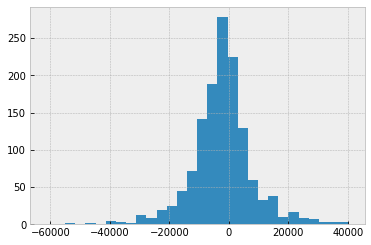

In [20]:
df_results.query('Exist_Fuel_Type == 4').NPV.hist(bins=30)
#xlim(-10000, 10000)

In [21]:
# Make a Break-even rule for use in multiple charts
rule_data = pd.DataFrame([{"ThresholdValue": 0, "Threshold": "breakeven"}])
rule = alt.Chart(rule_data).mark_rule(color='green').encode(
    x=alt.X('ThresholdValue', axis=alt.Axis(title='Net Present Value')),
    size=alt.value(2)
)

In [22]:
# Function to limit values in a Pandas Series to +/- some limit
def limit_vals(a_series, limit_value):
    """Returns an array that limits the values in the Pandas Series
    'a_sereies' to +/- 'limit_value'.
    """
    return np.where(
        a_series.abs() < limit_value, 
        a_series,
        limit_value * np.sign(a_series)
    )

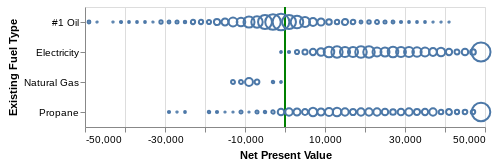

In [23]:
limit = 50000
df_results['npv_limited'] = limit_vals(df_results.NPV, limit)
main = alt.Chart(df_results, height=120).mark_point().encode(
    y=alt.Y('Exist_Fuel', axis=alt.Axis(title='Existing Fuel Type')),
    x=alt.X('npv_limited', bin=alt.Bin(maxbins=60), scale=alt.Scale(domain=(-limit, limit))),
    size=alt.Size('count()', legend=None)
)
rule + main

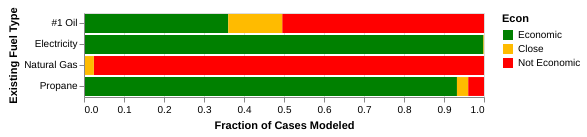

In [38]:
econ_color_scale = alt.Scale(
            domain=['Economic', 'Close', 'Not Economic'],
            range=['green', '#FFBB00', 'red'])

# Make an 'econ_order' field to sort the stacking of the bars
econ_order = {'Economic': 1, 'Close': 2, 'Not Economic': 3}
df_results['econ_order'] = df_results.Econ.map(econ_order)

cht = alt.Chart(df_results).mark_bar().encode(
    x=alt.X('count(Econ)', stack='normalize', axis=alt.Axis(title='Fraction of Cases Modeled')),
    y=alt.Y('Exist_Fuel', axis=alt.Axis(title='Existing Fuel Type')),
    color=alt.Color('Econ', scale=econ_color_scale),
    order='econ_order',
)
cht.save('images/by_fuel.png', scale_factor=1.5)
cht

In [43]:
pd.pivot_table(
    df_results, 
    values='City', 
    index='Econ', 
    columns='Exist_Fuel', 
    aggfunc='count',
    margins=True
)

Exist_Fuel,#1 Oil,Electricity,Natural Gas,Propane,All
Econ,,,,,
Close,181.0,2.0,2.0,28.0,213
Economic,484.0,1379.0,NaN,924.0,2787
Not Economic,677.0,NaN,79.0,39.0,795
All,1342.0,1381.0,81.0,991.0,3795


In [44]:
df_results.query('Exist_Fuel == "Electricity" and Econ == "Close"')

,ANCSA_Region,COP,Capital_Cost,Census_Area,City,Design_Heat_Load,Design_Heat_Temp,Elec_Rate_Incremental,Elec_Use_Chg,Elec_Use_Jan,...,IRR,Max_HP_Cap_Reached,NPV,PCE,Scenario,Sq_Ft,Util_Name,Econ,Exist_Fuel,econ_order
355,Arctic Slope Regional Corporation,2.674833,5690.494112,North Slope Borough,Barrow/Utqiavik,19438.467048,-34.06,0.1225,-3463.681017,539.454089,...,0.023163,False,-972.641660,0.0,Small Load,698.4,Barrow Utilities & Electric-elec - Residential,Close,Electricity,2
2164,Sealaska Corporation,3.234719,5059.644256,Prince of Wales-Hyder Census Area,Metlakatla,8061.684624,26.06,0.0925,-3501.975564,539.454089,...,0.002882,False,-1457.797615,0.0,Small Load,747.6,Metlakatla Power & Light - Residential,Close,Electricity,2


In [45]:
df_results.query('Exist_Fuel == "Natural Gas" and Econ == "Close"')

,ANCSA_Region,COP,Capital_Cost,Census_Area,City,Design_Heat_Load,Design_Heat_Temp,Elec_Rate_Incremental,Elec_Use_Chg,Elec_Use_Jan,...,IRR,Max_HP_Cap_Reached,NPV,PCE,Scenario,Sq_Ft,Util_Name,Econ,Exist_Fuel,econ_order
1109,Doyon,2.822556,4498.730602,Fairbanks North Star Borough,Fairbanks,58868.1324,-22.0,0.227998,4960.483389,674.317611,...,-0.000798,True,-1509.3601,0.0,Large Load,3102.0,Golden Valley Electric - Residential,Close,Natural Gas,2
1139,Doyon,2.822556,4498.730602,Fairbanks North Star Borough,Faribanks - Chena Ridge,58868.1324,-22.0,0.227998,4960.483389,674.317611,...,-0.000798,True,-1509.3601,0.0,Large Load,3102.0,Golden Valley Electric - Residential,Close,Natural Gas,2


In [46]:
df_results.query('Exist_Fuel == "Natural Gas"')['City'].unique()

array(['Anchor Point', 'Anchorage', 'Barrow/Utqiavik', 'Big Lake',
       'Bird Creek', 'Chugiak', 'Clam Gulch', 'Cooper Landing',
       'Eagle River', 'Fairbanks', 'Faribanks - Chena Ridge', 'Girdwood',
       'Homer', 'Hope', 'Houston', 'Indian', 'Kasilof', 'Kenai',
       'Moose Pass', 'Nikiski', 'Nikolaevsk', 'Ninilchik', 'Palmer',
       'Soldotna', 'Sterling', 'Wasilla', 'Whittier'], dtype=object)

In [25]:
main = alt.Chart(df_results).mark_bar().encode(
    x=alt.X('NPV', bin=alt.Bin(maxbins=60), axis=alt.Axis(title='Net Present Value')),
    y='count()',
    row='Exist_Fuel',
)
#(main + rule).facet(
#    column='Exist_Fuel'
#)

# Uncomment below to see chart, but not great
# main

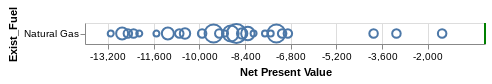

In [26]:
main = alt.Chart(df_results.query('Exist_Fuel_Type == 2')).mark_point().encode(
    y='Exist_Fuel',
    x=alt.X('NPV', bin=alt.Bin(maxbins=60)),
    size=alt.Size('count()', legend=None)
)
rule + main

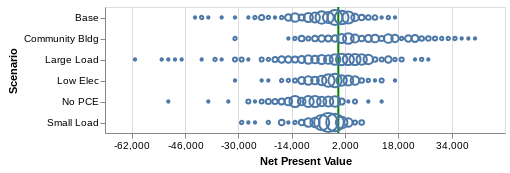

In [27]:
main = alt.Chart(df_results.query('Exist_Fuel_Type == 4')).mark_point().encode(
    y='Scenario',
    x=alt.X('NPV', bin=alt.Bin(maxbins=60)),
    size=alt.Size('count()', legend=None)
)
rule + main

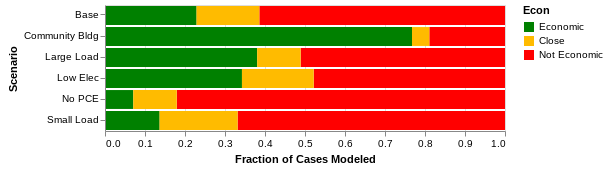

In [48]:
# Some data subsets, oil only
df_oil = df_results.query('Exist_Fuel_Type == 4').copy()
df_oil_pce = df_results.query('Exist_Fuel_Type == 4 and PCE > 0.0')
df_oil_no_pce = df_results.query('Exist_Fuel_Type == 4 and PCE == 0.0')

# PCE Communities
cht = alt.Chart(df_oil_pce).mark_bar().encode(
    x=alt.X('count(Econ)', stack='normalize', axis=alt.Axis(title='Fraction of Cases Modeled')),
    y='Scenario',
    color=alt.Color('Econ', scale=econ_color_scale),
    order='econ_order',
)
cht.save('images/pce_scenarios.png', scale_factor=1.5)
cht

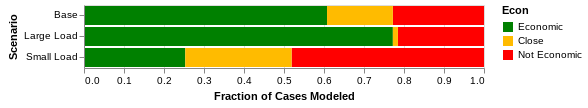

In [47]:
# Non-PCE Communities
cht = alt.Chart(df_oil_no_pce).mark_bar().encode(
    x=alt.X('count(Econ)', stack='normalize', axis=alt.Axis(title='Fraction of Cases Modeled')),
    y='Scenario',
    color=alt.Color('Econ', scale=econ_color_scale),
    order='econ_order',
)
cht.save('images/non_pce_scenarios.png', scale_factor=1.5)
cht

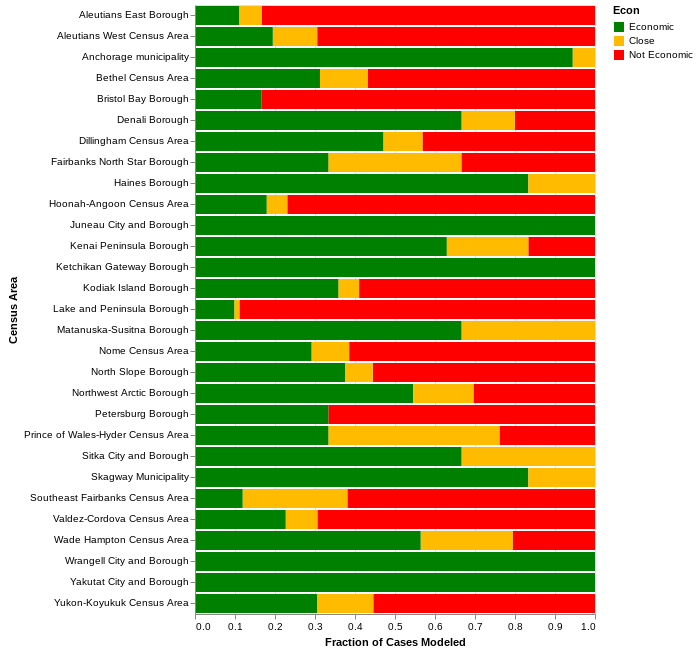

In [49]:
# Econ split by Census Area, oil only
cht = alt.Chart(df_oil).mark_bar().encode(
    x=alt.X('count(Econ)', stack='normalize', axis=alt.Axis(title='Fraction of Cases Modeled')),
    y=alt.Y('Census_Area', axis=alt.Axis(title='Census Area')),
    color=alt.Color('Econ', scale=econ_color_scale),
    order='econ_order',
)
cht.save('images/by_census_area.png', scale_factor=1.5)
cht

In [56]:
df_oil.groupby('Census_Area')[[
    'Elec_Rate_Incremental', 
    'Fuel_Price_Incremental',
    'COP',
    'PCE',
    'Elec_Use_Jan',
]].mean()

,Elec_Rate_Incremental,Fuel_Price_Incremental,COP,PCE,Elec_Use_Jan
Census_Area,,,,,
Aleutians East Borough,0.482773,3.779867,3.036097,0.344467,456.616046
Aleutians West Census Area,0.599898,4.867333,3.039688,0.383767,492.763682
Anchorage municipality,0.186572,3.151667,2.839513,0.000000,629.363104
Bethel Census Area,0.463730,5.376519,2.799242,0.341166,390.200338
Bristol Bay Borough,0.344489,2.770000,2.868676,0.257800,566.691271
Denali Borough,0.230734,3.525760,2.828595,0.000000,629.363104
Dillingham Census Area,0.406339,4.961794,2.873573,0.228165,403.074932
Fairbanks North Star Borough,0.229822,3.211600,2.771738,0.000000,629.363104
Haines Borough,0.233611,3.428750,2.957857,0.020000,461.621171


## Plotting of All Cases Run

In [69]:
areas = sorted(lib.df_city.census_area.unique())
' '.join(areas)

'Aleutians East Borough Aleutians West Census Area Anchorage municipality Bethel Census Area Bristol Bay Borough Denali Borough Dillingham Census Area Fairbanks North Star Borough Haines Borough Hoonah-Angoon Census Area Juneau City and Borough Kenai Peninsula Borough Ketchikan Gateway Borough Kodiak Island Borough Lake and Peninsula Borough Matanuska-Susitna Borough Nome Census Area North Slope Borough Northwest Arctic Borough Petersburg Borough Prince of Wales-Hyder Census Area Sitka City and Borough Skagway Municipality Southeast Fairbanks Census Area Valdez-Cordova Census Area Wade Hampton Census Area Wrangell City and Borough Yakutat City and Borough Yukon-Koyukuk Census Area'

In [70]:
# Make a Symbol Scale so that the same symbol is used for
# each scenario.  Found that in Census areas that didn't have
# any PCE, different symbols were being used for the Small and Large
# Load scenarios than in PCE census areas.
scenario_symbol_scale = alt.Scale(
            domain=['Base', 'Large Load', 'Small Load', 'Low Elec', 'Community Bldg', 'No PCE'],
            range=['circle', 'square', 'triangle-up', 'cross', 'diamond', 'triangle-right'])


In [72]:
npv_limit = 20000.
df_oil['npv_limited'] = limit_vals(df_oil.NPV, npv_limit)
for ca in cen_areas:
    print(ca)
    df_ca = df_oil.query('Census_Area == @ca')
    main = alt.Chart(df_ca).mark_point(
        size=150, opacity=0.7, stroke='black', strokeWidth=1
    ).encode(
        x=alt.X('npv_limited', axis=alt.Axis(title='Net Present Value', grid=False), scale=alt.Scale(domain=(-npv_limit, npv_limit))),
        y=alt.Y('City', axis=alt.Axis(title='Community', grid=True)),
        shape=alt.Shape('Scenario', scale=scenario_symbol_scale),
        color=alt.Color('Econ', scale=econ_color_scale),
        fill=alt.Color('Econ', scale=econ_color_scale),
        #tooltip=['Scenario']
    )
    (rule + main).save(f'images/census_area/{ca}.png', scale_factor=1.5)

Anchorage municipality
Aleutians West Census Area
Aleutians East Borough
Yukon-Koyukuk Census Area
Hoonah-Angoon Census Area
Bethel Census Area
Juneau City and Borough
North Slope Borough
Southeast Fairbanks Census Area
Matanuska-Susitna Borough
Denali Borough
Lake and Peninsula Borough
Valdez-Cordova Census Area
Prince of Wales-Hyder Census Area
Kenai Peninsula Borough
Northwest Arctic Borough
Nome Census Area
Wade Hampton Census Area
Dillingham Census Area
Bristol Bay Borough
Haines Borough
Yakutat City and Borough
Skagway Municipality
Sitka City and Borough
Wrangell City and Borough
Petersburg Borough
Ketchikan Gateway Borough
Kodiak Island Borough
Fairbanks North Star Borough


## Analysis of Other Results

### Design Heating Temperature

In [32]:
city_temp = list(set(zip(df_oil.City, df_oil.Design_Heat_Temp)))
df_dt = pd.DataFrame(city_temp, columns=['City', 'Design_Heat_Temp'])
df_dt.head()

,City,Design_Heat_Temp
0,Tanacross,-44.8600
1,Gulkana,-24.5938
2,Ninilchik,5.0000
3,Alatna,-34.9600
4,Tununak,-2.2000


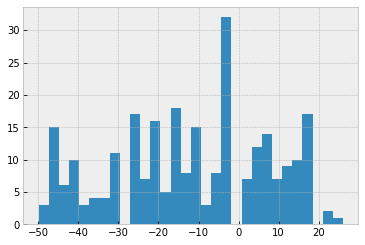

In [33]:
df_dt.Design_Heat_Temp.hist(bins=30)

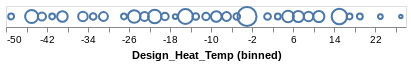

In [34]:
alt.Chart(df_dt).mark_point().encode(
    x=alt.X('Design_Heat_Temp', bin=alt.Bin(maxbins=40)),
    size=alt.Size('count()', legend=None)
)

### % of Heating Load Served by Heat Pump

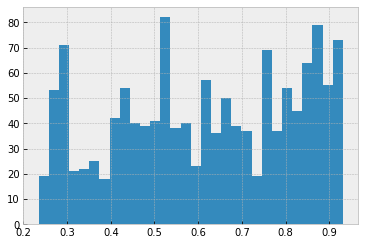

In [36]:
df_oil.HP_Load_Frac.hist(bins=30)

## Analysis of Seasonal COP

In [98]:
rcParams['font.size'] = 12.5            # set Font size in Chart

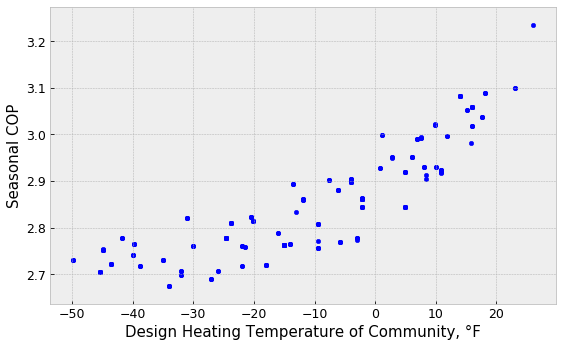

In [99]:
df_oil.query('Scenario == "Base"').plot(x='Design_Heat_Temp', y='COP', kind='scatter')
xlabel('Design Heating Temperature of Community, °F')
ylabel('Seasonal COP')
gcf().set_size_inches((8,5))
tight_layout()
savefig('images/seasonal_cop.png')

In [76]:
# COP Curve at any outdoor tempreature

from heatpump.home_heat_model import HomeHeatModel
# Use the curve from the Heat Pump Calculator
def cops_for_temps(temps, hspf):
    """Returns a numpy array of COPs for the associated array of 
    outdoor temperatures, passed in as 'temps'.  Calculates the 
    COPs for a heat pump with HSPF of 'hspf'.
    """
    cops = np.interp(temps, HomeHeatModel.TEMPS_FIT, HomeHeatModel.COPS_FIT)
    # my judgement on the 0.5 exponent; theory would say 1.0
    cops *= (hspf / HomeHeatModel.BASE_HSPF) ** 0.5
    return cops

# Test points to see if they match.  This is at Base HSPF
cops_for_temps([10.8, 34.5, 40], 11.33)

array([2.26766674, 3.01243964, 3.26991055])

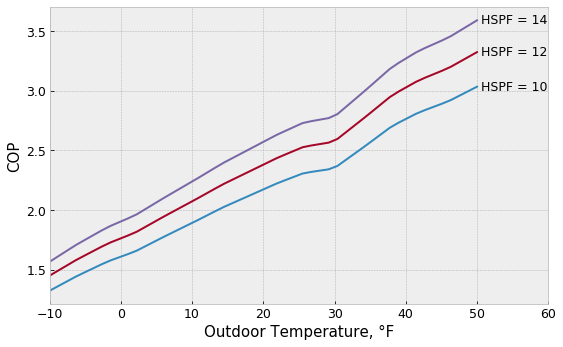

In [100]:
temps = np.linspace(-10, 50)
cops_10 = cops_for_temps(temps, 10.)
cops_12 = cops_for_temps(temps, 12.)
cops_14 = cops_for_temps(temps, 14.)
plot(temps, cops_10)
plot(temps, cops_12)
plot(temps, cops_14)
text(50.5, cops_10[-1], 'HSPF = 10', verticalalignment='center')
text(50.5, cops_12[-1], 'HSPF = 12', verticalalignment='center')
text(50.5, cops_14[-1], 'HSPF = 14', verticalalignment='center')
xlim(-10, 60)
xlabel('Outdoor Temperature, °F')
ylabel('COP')
gcf().set_size_inches((8,5))
tight_layout()
savefig('images/cop_vs_outdoor.png')